In [ ]:
LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']

In [ ]:
leg = ax.get_legend()


In [ ]:
from cycler import cycler

def plot_sensitivity_table(table, ax=None, **kwargs):
    
    ax = plt.gca() if ax is None else ax

#     ax.set_prop_cycle(cycler("marker", "s*v") + cycler("color", "rgb"))
    ax.set_prop_cycle(color=['red', 'green', 'blue'], marker=['>', 's', '8'], markersize=[5, 4.5, 5])

    for criterion in ("significance", "gamma", "bkg"):

        mask = table["criterion"] == criterion
        t = table[mask]

        ax.errorbar(
            t["e_ref"],
            t["e2dnde"],
            xerr=0.5 * (t["e_max"] - t["e_min"]),
            label=criterion,
            linestyle="",
        )

    ax.loglog()

    ax.set_xlabel(f"Energy [{t['e_ref'].unit.to_string(UNIT_STRING_FORMAT)}]")
    ax.set_ylabel(f"Sensitivity [{t['e2dnde'].unit.to_string(UNIT_STRING_FORMAT)}]")
    ax.legend(loc="lower left", scatterpoints=1, handlelength = 3, fontsize=8)

#     leg = ax.get_legend()
#     leg.legendHandles[0]._sizes = [25]
#     leg.legendHandles[1]._sizes = [25]

    return ax

In [ ]:
# idx=0
# irfs_opts, irfs, irfs_label, location = IRFS_OPTS[idx], IRFS[idx], IRFS_LABELS[idx], LOCATION[idx]

# irfs_opt = ['North', 'AverageAz', '20deg', '50h']
# irfs = Irfs.get_irfs(irfs_opt)
# irfs_label = Irfs.get_irfs_label(irfs_opt)
# location = Irfs.get_obs_loc(irfs_opt)

## CTA sensitivity for a point-like IRF 

[gammapy-tutorial](https://docs.gammapy.org/1.2/tutorials/analysis-1d/cta_sensitivity.html)</br>

[CTAO's expected "Alpha Configuration" performance](https://www.cta-observatory.org/science/ctao-performance/)

[CTAO Instrument Response Functions - prod5 version v0.1](https://zenodo.org/records/5499840#.YUya5WYzbUI)

[IRFs - gamma-astro-data-formats](https://gamma-astro-data-formats.readthedocs.io/en/v0.3/irfs/index.html)

In [129]:
%matplotlib inline

In [130]:
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u

from astropy.coordinates import Angle, SkyCoord
from astropy.visualization import quantity_support
from astropy.table import Table

from feupy.analysis.config import AnalysisConfig
from feupy.analysis.core import Analysis

from feupy.cta.irfs import Irfs

from feupy.utils.string_handling import name_to_txt
from feupy.utils.io import mkdir_sub_directory
from feupy.plotters import generate_marker_set

from core import irfs_label_txt, plot_sensitivity_table, set_sens_label

from gammapy.utils.scripts import make_path
from gammapy.maps.axes import UNIT_STRING_FORMAT

from gammapy.modeling.models import Models
from core import load_source_model

In [131]:
def plot_sensitivity_table(table, ax=None, wich = 'e2dnde', plot_xerr=False, **kwargs):
    
    ax = plt.gca() if ax is None else ax
    
    e_cta, ef_cta = table['e_ref'], table[wich]

    
    if plot_xerr == True:
        w = sens_table["e_max"] - sens_table["e_min"]
        xerr= w/2
    else: xerr = None

    with quantity_support():
        ax.errorbar(e_cta, ef_cta, xerr=xerr, **kwargs)

    ax.legend(loc= 'upper right', handlelength=4)
    ax.set_xlabel(f"Energy [{e_cta.unit.to_string(UNIT_STRING_FORMAT)}]", size=12)
    
    if wich == 'excess':
        ax.set_ylabel(f"Excess counts", size=12)
    elif wich == 'background':
        ax.set_ylabel(f"Background counts", size=12)
    elif wich == 'on_radii':
        ax.set_ylabel(f"On region radius [{ef_cta.unit.to_string(UNIT_STRING_FORMAT)}]", size=12)
    elif wich == 'e2dnde':
        ax.set_ylabel(f"Flux Sensitivity [{ef_cta.unit.to_string(UNIT_STRING_FORMAT)}]", size=12)
        
    ax.set_xscale('log')
    ax.set_yscale('log')
    return ax

In [132]:
def plot_sensitivity_from_table(sens_table, wich = 'e2dnde', ax=None, plot_xerr=False, **kwargs):
    """ """

    ax = plt.gca() if ax is None else ax

    e = sens_table["e_ref"]
    s = sens_table[wich]
    
    xlabel = f"Energy [{sens_table['e_ref'].unit.to_string(UNIT_STRING_FORMAT)}]"
    if wich == 'excess':
        ylabel = 'Excess counts'
    elif wich == 'background':
        ylabel = "Background counts"
    elif wich == 'on_radii':
        ylabel = f"On region radius [{e.unit.to_string(UNIT_STRING_FORMAT)}]"
    elif wich == 'e2dnde':
         ylabel = f"Flux Sensitivity [{e.unit.to_string(UNIT_STRING_FORMAT)}]"
        
    if plot_xerr == True:
        w = sens_table["e_max"] - sens_table["e_min"]
        xerr= w/2
    else: xerr = None
   
    with quantity_support():
        ax.errorbar(
            e,
            s,
            xerr=xerr,
            **kwargs,
        )

    ax.set_xscale("log")
    ax.set_yscale("log")
    
    # Style settings
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc="lower left", scatterpoints=1, handlelength = 3, fontsize=8)

    return ax

In [220]:
source_name = 'NGC 1275'
file_name = name_to_txt(source_name)
position = SkyCoord.from_name(source_name)
print(f'{position.ra.deg:.2f}, {position.dec.deg:.2f}')
print(f'{position.galactic.l.deg:.2f}, {position.galactic.b.deg:.2f}')

49.95, 41.51
150.58, -13.26


In [221]:
outdir = f"./{name_to_txt(source_name)}"
outdir_path = mkdir_sub_directory(outdir)
datasets_path = mkdir_sub_directory(outdir, 'datasets')[1]
figures_path = mkdir_sub_directory(outdir, 'figures')[1]
sensitivity_path = mkdir_sub_directory(outdir, 'sensitivity')[1]
data_path = mkdir_sub_directory(outdir, 'data')[1]

Directory 'NGC_1275' created
Directory 'NGC_1275/datasets' created
Directory 'NGC_1275/figures' created
Directory 'NGC_1275/sensitivity' created
Directory 'NGC_1275/data' created


In [222]:
config = AnalysisConfig()

In [223]:
# datasets_sens =  Datasets.read(f'{datasets_path}/sensitivity_datasets.yaml')
# fig, ax = plt.subplots()
# ax.set_prop_cycle(color=['red', 'green', 'blue'], marker=['>', 's', '8'], markersize=[5, 4.5, 5])
# ax = plot_sensitivity_from_table(tables_north[0], ax=ax)
# ax = plot_sensitivity_from_table(tables_north[1], ax=ax)
# ax = plot_sensitivity_from_table(tables_north[2], ax=ax)

In [224]:
colors = ['blue', 'green']
lines = ['solid', 'dotted', (0, (1, 10))]

In [225]:
tables_south = [] 
tables_south_names = []

_irfs =[
    ['South'], 
    ['AverageAz'], 
    ['20deg','40deg','60deg'], 
    ['50h']
]
irfs_opts, irfss, irfs_labels, locations = Irfs.get_irf_groups(_irfs)
IRFS_OPTS_SOUTH = irfs_opts

for i, irfs_opt in enumerate(IRFS_OPTS_SOUTH):
    path = f"/home/born-again/Documents/GitHub/radio_galaxies/{file_name}/tables/sens-{irfs_label_txt(irfs_opt)}.csv"
    table = Table.read(path, format='ascii')
    tables_south_names.append(table.meta['irfs_label'])
    tables_south.append(table)

In [226]:
markers_south = generate_marker_set(tables_south_names, 2.5)

3 unique markers generated


In [227]:
tables_north = [] 
tables_north_names = []

_irfs =[
    ['North'], 
    ['AverageAz'], 
    ['20deg','40deg','60deg'], 
    ['50h']
]
irfs_opts, irfss, irfs_labels, locations = Irfs.get_irf_groups(_irfs)
IRFS_OPTS_NORTH = irfs_opts

for i, irfs_opt in enumerate(IRFS_OPTS_NORTH):
    path = f"/home/born-again/Documents/GitHub/radio_galaxies/{file_name}/tables/sens-{irfs_label_txt(irfs_opt)}.csv"
    table = Table.read(path, format='ascii')
    tables_north_names.append(table.meta['irfs_label'])
    tables_north.append(table)

In [228]:
markers_north = generate_marker_set(tables_north_names, 2.5)

3 unique markers generated


In [229]:
linestyle = ['solid', (0, (5, 1)), (0, (3, 5, 1, 5))]

In [230]:
# fig, ax = plt.subplots()
# ax.set_prop_cycle(color=['blue', 'blue', 'blue'], linestyle=linestyle)
# for index, (table, label) in enumerate(zip(tables_south, tables_south_names)):
#     int_sens = u.Quantity(table.meta['int_sens'])
#     unit = int_sens.unit.to_string(UNIT_STRING_FORMAT)
#     label = label.replace('-50h)', '').replace(' (', '-')
#     label = f'{label} ({int_sens.value:.2e} {unit})'
#     ax = plot_sensitivity_from_table(table, wich='background',  ax=ax, label=label)

In [231]:
path = f"/home/born-again/Documents/GitHub/radio_galaxies/{file_name}/datasets/"
sky_model = load_source_model(path)
display(sky_model.parameters.to_table())

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,str1
spectral,amplitude,3.8931e-11,MeV-1 s-1 cm-2,2.933e-13,nan,nan,False,True,
spectral,reference,9.1798e+02,MeV,0.000e+00,nan,nan,True,False,
spectral,alpha,1.9613e+00,,7.311e-03,nan,nan,False,False,
spectral,beta,9.6899e-02,,2.859e-03,nan,nan,False,False,


In [232]:
spec_model = sky_model.spectral_model
e_edges_min = 3.2e-02*u.TeV
e_edges_max = 1.0e+02*u.TeV

energy_bounds = [e_edges_min, e_edges_max]

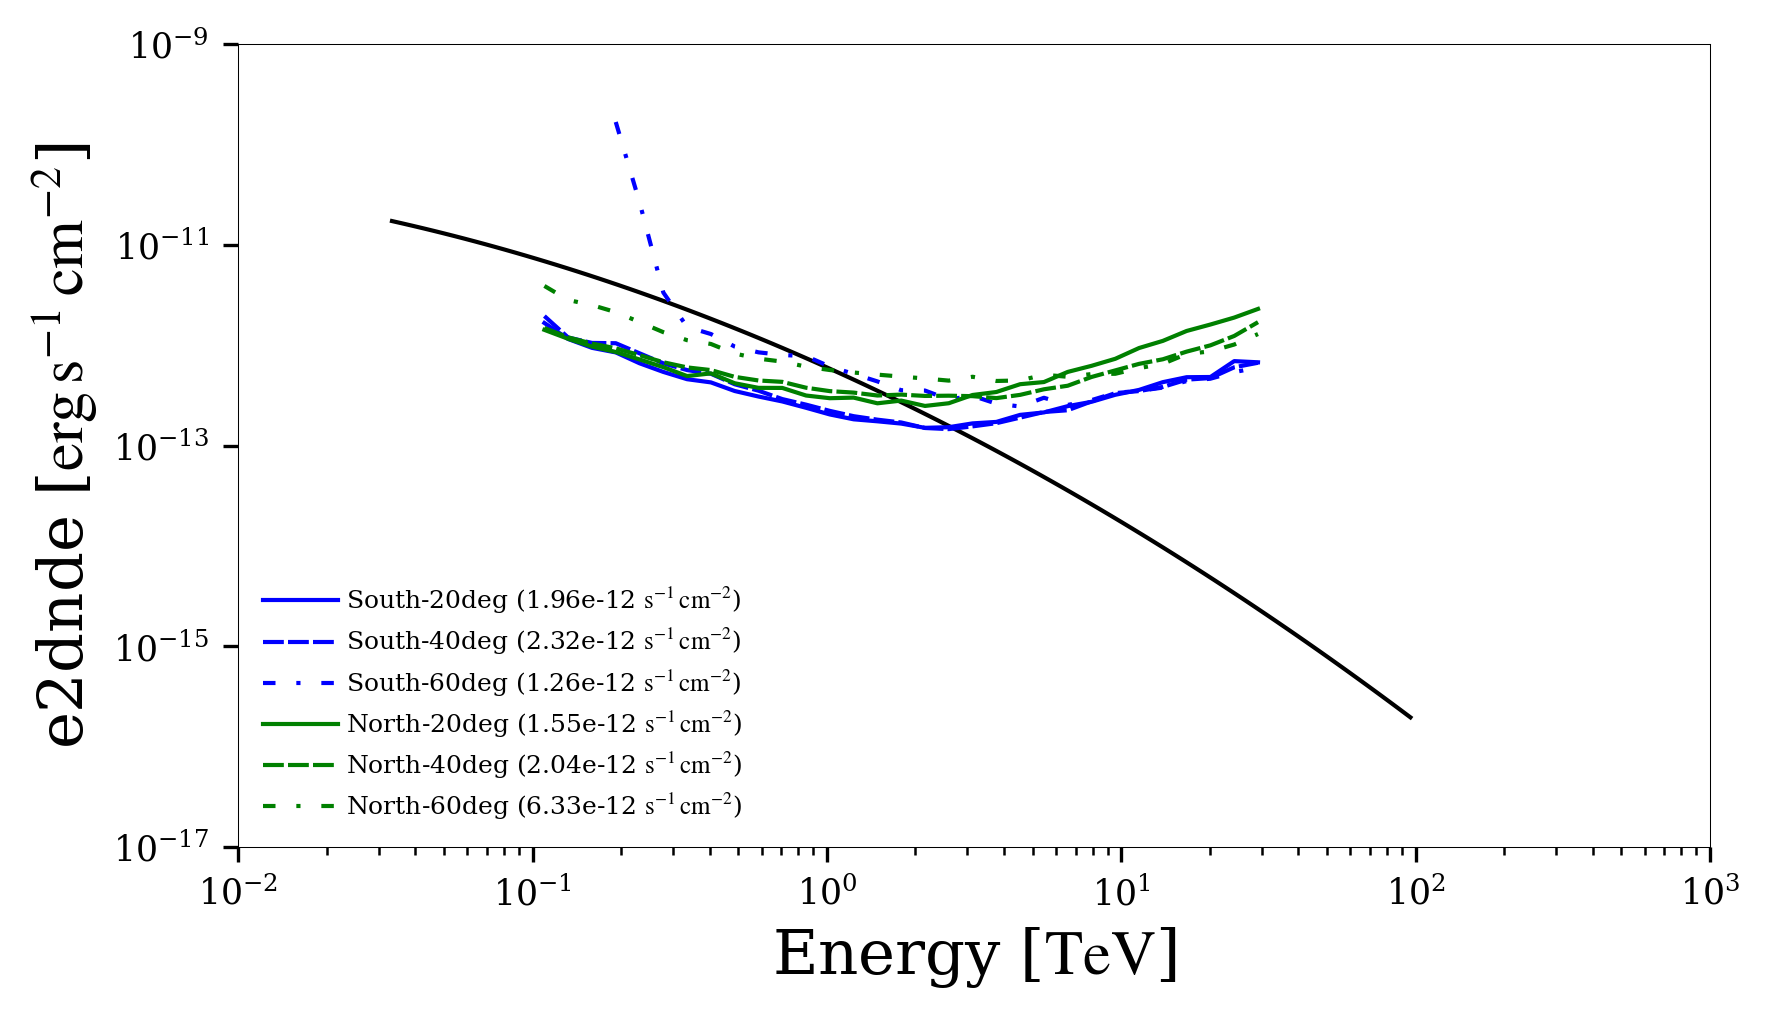

In [233]:
fig, ax = plt.subplots()
ax.set_prop_cycle(color=['blue', 'blue', 'blue'], linestyle=linestyle)
for index, (table, label) in enumerate(zip(tables_south, tables_south_names)):
    int_sens = u.Quantity(table.meta['int_sens'])
    unit = int_sens.unit.to_string(UNIT_STRING_FORMAT)
    label = label.replace('-50h)', '').replace(' (', '-')
    label = f'{label} ({int_sens.value:.2e} {unit})'
    ax = plot_sensitivity_from_table(table, wich='e2dnde',  ax=ax, label=label)

ax.set_prop_cycle(color=['green', 'green', 'green'], linestyle=linestyle)
for index, (table, label) in enumerate(zip(tables_north, tables_north_names)):
    int_sens = u.Quantity(table.meta['int_sens'])
    unit = int_sens.unit.to_string(UNIT_STRING_FORMAT)
    label = label.replace('-50h)', '').replace(' (', '-')
    label = f'{label} ({int_sens.value:.2e} {unit})'
    
    ax = plot_sensitivity_from_table(table,wich='e2dnde', ax=ax, label=label)

ax.legend(loc="best", scatterpoints=1, handlelength = 3, fontsize=6)
spec_model.plot(energy_bounds, sed_type= 'e2dnde', ax=ax, color ='black')
plt.savefig(fname = f"/home/born-again/Documents/GitHub/radio_galaxies/{file_name}/figures/{file_name}_sites.png")

In [234]:
tables_south = [] 
tables_south_names = []

_irfs =[
    ['South', 'South-SSTSubArray', 'South-MSTSubArray'], 
    ['AverageAz'], 
    ['40deg'], 
    ['50h']
]
irfs_opts, irfss, irfs_labels, locations = Irfs.get_irf_groups(_irfs)
IRFS_OPTS_SOUTH = irfs_opts

for i, irfs_opt in enumerate(IRFS_OPTS_SOUTH):
    path = f"/home/born-again/Documents/GitHub/radio_galaxies/{file_name}/tables/sens-{irfs_label_txt(irfs_opt)}.csv"
    table = Table.read(path, format='ascii')
    tables_south_names.append(table.meta['irfs_label'])
    tables_south.append(table)

In [235]:
markers_south = generate_marker_set(tables_south_names, 2.5)

3 unique markers generated


In [236]:
tables_north = [] 
tables_north_names = []

_irfs =[
    ['North', 'North-MSTSubArray', 'North-LSTSubArray'], 
    ['AverageAz'], 
    ['40deg'], 
    ['50h']
]
irfs_opts, irfss, irfs_labels, locations = Irfs.get_irf_groups(_irfs)
IRFS_OPTS_NORTH = irfs_opts

for i, irfs_opt in enumerate(IRFS_OPTS_NORTH):
    path = f"/home/born-again/Documents/GitHub/radio_galaxies/{file_name}/tables/sens-{irfs_label_txt(irfs_opt)}.csv"
    table = Table.read(path, format='ascii')
    tables_north_names.append(table.meta['irfs_label'])
    tables_north.append(table)

In [237]:
markers_north = generate_marker_set(tables_north_names, 2.5)

3 unique markers generated


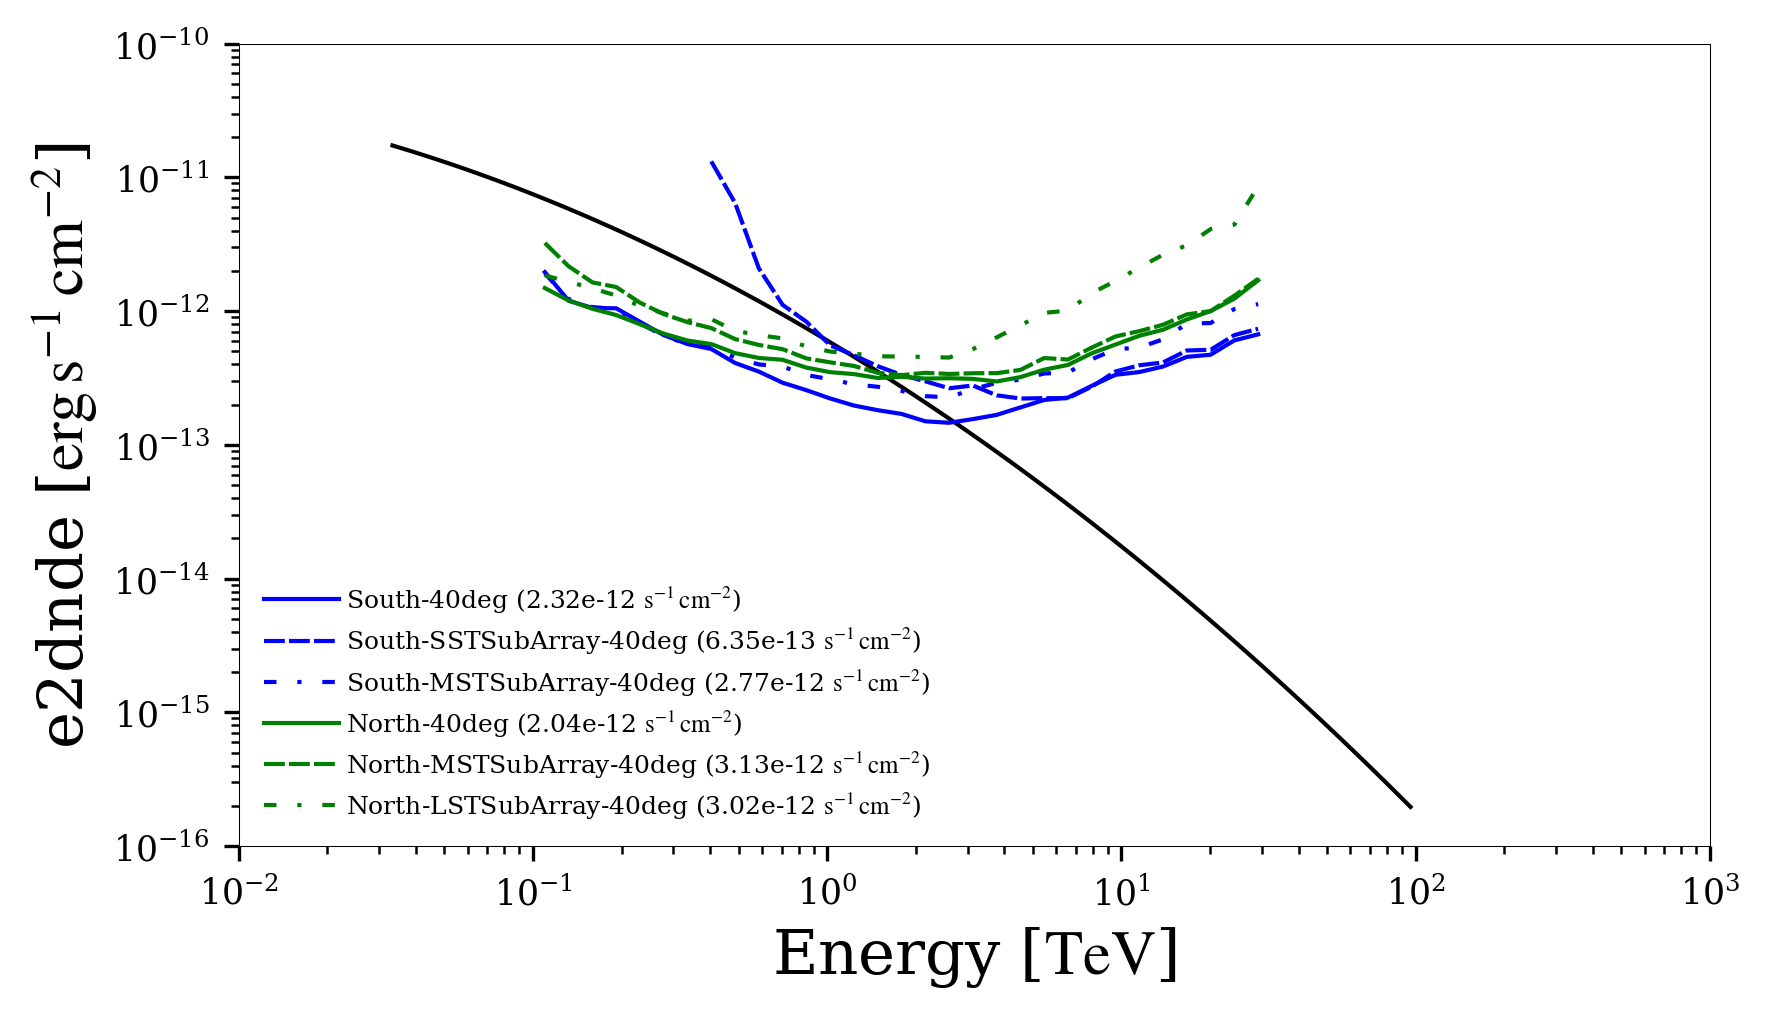

In [238]:
fig, ax = plt.subplots()
ax.set_prop_cycle(color=['blue', 'blue', 'blue'], linestyle=linestyle)
for index, (table, label) in enumerate(zip(tables_south, tables_south_names)):
    int_sens = u.Quantity(table.meta['int_sens'])
    unit = int_sens.unit.to_string(UNIT_STRING_FORMAT)
    label = label.replace('-50h)', '').replace(' (', '-')
    label = f'{label} ({int_sens.value:.2e} {unit})'
    ax = plot_sensitivity_from_table(table, wich='e2dnde',  ax=ax, label=label)

ax.set_prop_cycle(color=['green', 'green', 'green'], linestyle=linestyle)
for index, (table, label) in enumerate(zip(tables_north, tables_north_names)):
    int_sens = u.Quantity(table.meta['int_sens'])
    unit = int_sens.unit.to_string(UNIT_STRING_FORMAT)
    label = label.replace('-50h)', '').replace(' (', '-')
    label = f'{label} ({int_sens.value:.2e} {unit})'
    
    ax = plot_sensitivity_from_table(table,wich='e2dnde', ax=ax, label=label)

ax.legend(loc="best", scatterpoints=1, handlelength = 3, fontsize=6)
spec_model.plot(energy_bounds, sed_type= 'e2dnde', ax=ax, color ='black')
plt.savefig(fname = f"/home/born-again/Documents/GitHub/radio_galaxies/{file_name}/figures/{file_name}_subarrays.png")

In [ ]:
plot_sensitivity_table(tables_south[0])

In [ ]:
def show_sensitivity_curve(table, ax=None, **kwargs):
    # Plot the sensitivity curve
    
    is_s = table["criterion"] == "significance"
    is_g = table["criterion"] == "gamma"
    is_bkg_syst = table["criterion"] == "bkg"
    
    fig, ax = plt.subplots()
    marker = markers['significance']
    ax.plot(table["e_ref"][is_s], table["e2dnde"][is_s], 
             color="red", label="significance",  
            marker=marker[1], markersize=marker[2]
           )
    marker = markers['gamma']
    ax.plot(table["e_ref"][is_g], table["e2dnde"][is_g], 
            color="blue", label="gamma",
            marker=marker[1], markersize=marker[2]
           )
    marker = markers['bkg syst']
    ax.plot(table["e_ref"][is_bkg_syst], table["e2dnde"][is_bkg_syst],
            color="green", label="bkg syst",
                       marker=marker[1], markersize=marker[2]

)

    ax.loglog()
#     # ax.set_xlabel(f"Energy [{table['e_ref'].unit.to_string(UNIT_STRING_FORMAT)}]")
#     # ax.set_ylabel(f"Sensitivity [{table['e2dnde'].unit.to_string(UNIT_STRING_FORMAT)}]")
#     ax.legend()

    return ax

In [ ]:
#         label=label, 
#         c=marker[0],
#         marker=marker[1],
#         markersize=marker[2],
#         ls='None',
#         mec='k',
#         mew=0.5,
#         elinewidth=0.7,
#         capsize=1.5,

In [ ]:
labels = ['significance', "gamma", 'bkg syst']
colors = ['red', 'blue', 'green']


In [ ]:
markers = generate_marker_set(labels, 4)
markers

In [ ]:
show_sensitivity_curve(tables_south[1])

In [ ]:


from feupy.utils.table import write_tables_fits, write_tables_csv
from feupy.utils.datasets import flux_points_dataset_from_table
from feupy.utils.observation import get_obs_label

from feupy.utils.geometry import (
    create_energy_axis, 
    create_pointing, 
    create_pointing_position, 
    create_region_geometry,
    define_on_region,
)


from gammapy.datasets import Datasets
from gammapy.maps import MapAxis

from gammapy.datasets import SpectrumDataset, SpectrumDatasetOnOff, Datasets
from gammapy.makers import SpectrumDatasetMaker, SafeMaskMaker
from gammapy.estimators import FluxPoints, SensitivityEstimator

from gammapy.data import Observation

In [ ]:
# fig, ax = plt.subplots()

# tables = tables_north
# tables_names =  tables_north_names
# markers = markers_north

# marker, label = markers['label'], set_sens_label(tables_names[0], livetime_out='50h')
# ax = plot_sensitivity_table(tables[0], ax=ax, wich='background')
# ax = plot_sensitivity_table(tables[1], ax=ax, wich='background')
# ax = plot_sensitivity_table(tables[1], ax=ax, wich='background')


# ax.set_xlim(plot_kwargs["energy_bounds"])
# # ax.set_xlabel(sed_x_label)
# # ax.set_ylabel(sed_y_label)
# ax.legend(loc="lower left")

In [ ]:
datasets = Datasets()
for dataset in datasets_sens:
    name = dataset.name
    if name.find('sens') != -1 and name.find('40deg') != -1 and name.find('Az') != -1:             
        datasets.append(dataset)

In [ ]:
fig, ax = plt.subplots()
kwargs = {}
for index, dataset in enumerate(datasets):
    if index in [0, 1, 2]:
        kwargs['color'] = 'green'
    else: kwargs['color'] = 'blue'
    label = set_sens_label(dataset.name, livetime_out='25h', zenith_out='40deg')
    kwargs['label'] = label
    kwargs['ls'] = lines[index]
    kwargs['mec'] = 'k'                
    
    ax = plot_sensitivity_cta(dataset=dataset, **kwargs)

In [ ]:
fig, ax = plt.subplots()
kwargs = {}
for index, dataset in enumerate(datasets):
#     if index in [0, 1, 2]:
    name = dataset.name
    marker = markers[name]
    label = set_sens_label(dataset, livetime_out='25h', zenith_out='40deg')
    if label.find('South') != -1:
        ls = '--'
    else:  ls = 'None'
        
    kwargs = {
            'c':marker[0],
        'marker':marker[1],
        'markersize':marker[2],
        'ls':ls,
        'mec':'k',
        'mew':0.5,
        'elinewidth':0.7,
        'capsize':1.5
        }


    kwargs['label'] = label
#     kwargs['ls'] = lines[index]
#     kwargs['mec'] = 'k'                
    
    ax = plot_sensitivity_cta(dataset=dataset, **kwargs)

In [ ]:
dataset.name

In [ ]:
irfs_config =[
    ['South', 'South-SSTSubArray','South-MSTSubArray','North','North-MSTSubArray', 'North-LSTSubArray'], 
    ['AverageAz'], 
    ['20deg','40deg','60deg'], 
    ['50h']
]
irfs_opts, irfss, irfs_labels, locations = Irfs.get_irf_groups(irfs_config)

In [ ]:
from config import irfs_label_txt

In [ ]:
tables_north_z40 = [] 
table_north_z40_names = []

_irfs =[
    ['North','North-MSTSubArray', 'North-LSTSubArray'], 
    ['AverageAz'], 
    ['40deg'], 
    ['50h']
]
irfs_opts, irfss, irfs_labels, locations = Irfs.get_irf_groups(_irfs)
IRFS_OPTS_NORTH_z40 = irfs_opts

for i, irfs_opt in enumerate(IRFS_OPTS_NORTH_z40):
    path = f'{sensitivity_path}/sens-{irfs_label_txt(irfs_opt)}.csv'
    table = Table.read(path, format='ascii')
    table_north_z40_names.append(table.meta['irfs_label'])
    tables_north_z40.append(table)

In [ ]:
tables_south = [] 
table_names = []
for i, (irfs_opt, irfs, irfs_label, location) in enumerate(zip(irfs_opts, irfss, irfs_labels, locations)):
    path = f'{sensitivity_path}/sens-{irfs_label_txt(irfs_opt)}.csv'
    table = Table.read(path, format='ascii')
    table_names.append(table.meta['irfs_label'])
    tables.append(table)
    

In [ ]:
markers

In [ ]:
datasets = Datasets()
for dataset in datasets_sens:
    name = table.meta['irfs_label']
    if name.find('sens') != -1 and name.find('40deg') != -1 and name.find('Az') != -1:             
        datasets.append(dataset)

In [ ]:
sed_x_label = "Energy / TeV"
sed_y_label = (
    r"$E^2\,{\rm d}\phi/{\rm d}E\,/\,({\rm erg}\,{\rm cm}^{-2}\,{\rm s}^{-1})$"
)

In [ ]:
plot_kwargs = {
    "energy_bounds": [0.01, 300] * u.TeV,
    "sed_type": "e2dnde",
    "yunits": u.Unit("erg cm-2 s-1"),
    "xunits": u.TeV,
}

In [ ]:
ax.set_xlim(plot_kwargs["energy_bounds"])
ax.set_xlabel(sed_x_label)
ax.set_ylabel(sed_y_label)
ax.legend(loc="lower left")
fig.savefig("multi_instrument_analysis.pdf")

In [ ]:
    label = set_sens_label(dataset, livetime_out='50h', zenith_out='40deg')
    kwargs['label'] = label
    kwargs['ls'] = lines[index]
    kwargs['mec'] = 'k'

In [ ]:
markers = generate_marker_set(tables_north_names, 5)

In [ ]:
from feupy.plotters.config import PATHMYSTYLE

plt.style.use(make_path(PATHMYSTYLE))

In [ ]:
tables_north_names

In [ ]:
fig, ax = plt.subplots()

table, label = tables_north[0], tables_north_names[0]
marker, label = markers[label], set_sens_label(tables_north_names[0], livetime_out='50h')
ax = plot_sensitivity_table(tables[0], ax=ax, wich='background', **kwargs)
ax = plot_sensitivity_table(tables[1], ax=ax, wich='background')
ax = plot_sensitivity_table(tables[1], ax=ax, wich='background')


ax.set_xlim(plot_kwargs["energy_bounds"])
# ax.set_xlabel(sed_x_label)
# ax.set_ylabel(sed_y_label)
ax.legend(loc="lower left")

In [ ]:
fig, ax = plt.subplots()
kwargs = {}
site_name = 'South'
for index, (table, name) in enumerate(zip(tables_south, tables_south_names)):
    marker = markers[name]
    label = table.meta['irfs_label']
    if label.find('20deg') != -1:
        ls = lines[0]
    elif label.find('40deg') != -1:
        ls =  lines[1]
    else: ls =  lines[2]       
        
    kwargs = {
            'c':marker[0],
        'marker':marker[1],
        'markersize':marker[2],
        'ls':ls,
        'mec':'k',
        'mew':0.5,
        'elinewidth':0.7,
        'capsize':1.5
        }


    kwargs['label'] = label
#     kwargs['ls'] = lines[index]
#     kwargs['mec'] = 'k'                
    
    ax = plot_sensitivity_table(table, wich='background', **kwargs)

site_name = 'North'
for index, (table, name) in enumerate(zip(tables_north, tables_north_names)):
    marker = markers[name]
    label = table.meta['irfs_label']
    if label.find('20deg') != -1:
        ls = lines[0]
    elif label.find('40deg') != -1:
        ls =  lines[1]
    else: ls =  lines[2]       
        
    kwargs = {
        'c':marker[0],
        'marker':marker[1],
        'markersize':marker[2],
        'ls':ls,
        'mec':'k',
        'mew':0.5,
        'elinewidth':0.7,
        'capsize':1.5
        }


    kwargs['label'] = label
#     kwargs['ls'] = lines[index]
#     kwargs['mec'] = 'k'                
    
    ax = plot_sensitivity_table(table, wich='background', **kwargs)


In [ ]:
table.meta

In [ ]:
fig, ax = plt.subplots()
kwargs = {}
site_name = 'South'
for index, (table, name) in enumerate(zip(tables_south, tables_south_names)):
    marker = markers[site_name]
    label = table.meta['irfs_label']
    if label.find('20deg') != -1:
        ls = lines[0]
    elif label.find('40deg') != -1:
        ls =  lines[1]
    else: ls =  lines[2]       
        
    kwargs = {
            'c':marker[0],
        'marker':marker[1],
        'markersize':marker[2],
        'ls':ls,
        'mec':'k',
        'mew':0.5,
        'elinewidth':0.7,
        'capsize':1.5
        }


    kwargs['label'] = label
#     kwargs['ls'] = lines[index]
#     kwargs['mec'] = 'k'                
    
    ax = plot_sensitivity_table(table, wich='background', **kwargs)


In [ ]:
def plot_sensitivity_ON_radius(table, witch = 'excess', ax=None, file_path=None, **kwargs):
    on_radii = table['on_radii']
    
    # Plot expected number of counts for signal and background
    fig, ax1 = plt.subplots()
    kwargs.setdefault('ms', 3.5)
    if witch == 'excess':
        t_ = table["excess"]
        yax_title = "Expected excess counts"
    else: 
        t_ = table["background"]
        yax_title = "Expected bkg counts"
        
    ax1.plot( table["e_ref"],t_,"o", color="black", label="signal", **kwargs)

    ax1.loglog()
    ax1.set_xlabel(f"Energy [{table['e_ref'].unit.to_string(UNIT_STRING_FORMAT)}]")
    ax1.set_ylabel(yax_title)

    ax2 = ax1.twinx()
    ax2.set_ylabel(
        f"ON region radius [{on_radii.unit.to_string(UNIT_STRING_FORMAT)}]", color="red"
    )
    ax2.semilogy(table["e_ref"], on_radii,"o", color="red", label="PSF68", **kwargs)
    ax2.tick_params(axis="y", labelcolor="red")
    ax2.set_ylim(0.01, 0.5)

    source = table.meta['source']
    irfs_label = table.meta['irfs_label']
    print(f'{source} - {irfs_label}')
    ax1.text(.5, .9, f'{source} - {irfs_label}', fontsize=8, transform=ax1.transAxes)
    # sed_type = "e2dnde"    
    # source.flux_points.plot(ax=ax, sed_type="e2dnde")

    # sky_model.spectral_model.plot(ax=ax, energy_bounds=energy_bounds, sed_type=sed_type, label="Model")
    # ax.legend()
    ax1.set_xlim(energy_bounds)

    if file_path:
        plt.savefig(file_path, bbox_inches='tight')
#     plt.grid(which="both")
    plt.show()


In [ ]:
 energy_bounds = [4e-2, 3e2]
plot_sensitivity_ON_radius(table, table['on_radii'])

In [ ]:


config.general.outdir = outdir
config.general.datasets_file = f'{datasets_path}/datasets.yaml'
config.general.models_file = f'{datasets_path}/models.yaml'

In [ ]:
analysis = Analysis(config)
analysis.read_datasets()